In [7]:
from lcode2dPy.simulation.interface import Simulation, Diagnostics2d
from lcode2dPy.config.default_config import default_config
from lcode2dPy.beam.beam_generator import make_beam, Gauss, rGauss
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Config
config = default_config
config.set('time-step', 1000)
config.set('time-limit', 20000)
config.set('window-length', 30)

# Beam
gamma = 426
angspread = 1e-5
m_proton = 958/0.51

beam_pars = dict(xi_distr=Gauss(sigma=100, vmin=-300, vmax=0),
                r_distr=rGauss(vmin=0, vmax=16),
                ang_distr=Gauss(sigma=angspread, vmin=None, vmax=None),
                pz_distr=Gauss(gamma*m_proton, gamma*m_proton*1e-4, vmin=None, vmax=None),
                Ipeak_kA=40/1000,
                q_m=1/m_proton)

# Diagnostics
def E_z_diag(diagnostics, t, layer_idx, plasma_particles, plasma_fields, rho_beam, beam_slice,
             t_start, t_end, period, r_selected):
    time_step = diagnostics.config.getfloat('time-step')
    if t < t_start or t > t_end:
        return
    if t <= t_start + time_step and layer_idx == 0:
        diagnostics.Ez = {}
    if (t - t_start) % period != 0:
        return
    if layer_idx == 0:
        diagnostics.Ez[t] = []
    r_grid_steps = plasma_fields.E_z.size
    rs = np.linspace(0, diagnostics.config.getfloat('window-width'), r_grid_steps)
    E_z_selected = plasma_fields.E_z[rs == r_selected][0]
    diagnostics.Ez[t].append(E_z_selected)
    return E_z_selected

E_z_diag_pars = dict(t_start = 0,
                     t_end = config.getfloat('time-limit'),
                     period = 5000,
                     r_selected = 0
                    )

dxi_diag = dict(E_z=[E_z_diag, E_z_diag_pars])


# Setting up simulation
diagnostics = Diagnostics2d(dt_diag=None, dxi_diag=dxi_diag)

sim = Simulation(beam_pars=beam_pars, diagnostics=diagnostics, config=config)

In [9]:
sim.step(1)

Number of particles: 236448
Number of particles in the middle layer: 200


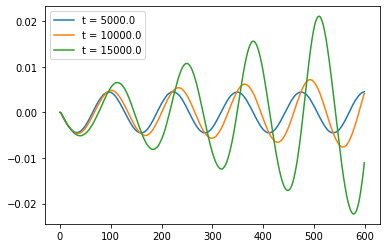

In [15]:
for key in diagnostics.Ez.keys():
    plt.plot(diagnostics.Ez[key], label=f't = {key}')
plt.legend()

In [16]:
beam_slice = sim.beam_source.get_beam_slice(10, -config.getfloat('window-length'))

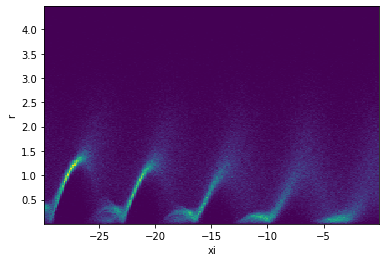

In [17]:
beam = beam_slice.particles
plt.hist2d(beam['xi'], beam['r'], 200);
plt.xlabel('xi')
plt.ylabel('r');